In [ ]:
#hide
#default_exp tools.metric_visualization
from nbdev.showdoc import show_doc

# Metric visualization

> Visualize metrics collected from experiments.

In [ ]:
#export
import warnings
warnings.filterwarnings('ignore')

import argparse
import sys
sys.path.append('.')
sys.path.append('src')
import pandas as pd
import pickle
import hpsearch.visualization.experiment_visualization as ev
from hpsearch.config.hpconfig import get_path_experiments
from hpsearch.config.hpconfig import get_default_operations

def metric_visualization (experiments=[-1,-2], run_number=0, root_folder=None, metric=None, op = None,
                          parameters=None, name_file='model_history.pk', visualization_options = {},
                          backend='plotly'):
    
    default_operations = get_default_operations ()
    if root_folder is None:
        root_folder = default_operations.get('root', 'results')
    if metric is None:
        metric = default_operations.get('metric', 'accuracy')
    if op is None:
        op = default_operations.get('op', 'min')
        
    # metrics
    if type(metric) is str:
        metrics = [metric]
    else:
        metrics = metric
        
    for i in range(len(experiments)):
        if experiments[i] == -1:
            root_path = get_path_experiments (folder = root_folder)
            experiment_number = pickle.load(open('%s/current_experiment_number.pkl' %root_path,'rb'))
            experiments[i] = experiment_number

        if experiments[i] == -2:
            root_path = get_path_experiments (folder = root_folder)
            df = pd.read_csv('%s/experiments_data.csv' %root_path,index_col=0)
            if op=='max':
                experiments[i] = df['0_%s' %metric].idxmax()
            else:
                experiments[i] = df['0_%s' %metric].idxmin()
    
    if 'visualization' in visualization_options.keys():
        visualization = visualization_options.pop('visualization')
    else:
        visualization = 'history'
    
    ev.visualize_experiments(visualization=visualization, 
                             experiments=experiments, run_number=run_number, root_folder=root_folder,metrics=metrics, 
                             parameters=parameters, name_file=name_file, **visualization_options,
                             backend=backend)

def parse_args(args):
    parser = argparse.ArgumentParser(description='show metrics about experiments') 
    # Datasets
    parser.add_argument('-e', nargs='+', default=[-1, -2], type=int,
                        help="experiments")
    parser.add_argument('-m', '--metric', nargs='+', type=str, default=None, help="metrics")
    parser.add_argument('--root', type=str, default=None)
    parser.add_argument('-l','--labels',nargs='+', default=None, type=str)
    parser.add_argument('--run', default=0, type=int)
    parser.add_argument('--op', default=None, type=str)
    parser.add_argument('-b', '--backend', default='visdom', type=str)
    parser.add_argument('-f', '--file', default='model_history.pk', type=str)
    parser.add_argument('-v', '--visualization', default='{}', type=str)

    pars = parser.parse_args(args)
    
    pars.visualization = eval(pars.visualization)
    
    return pars

def parse_arguments_and_visualize (args):
    
    pars = parse_args(args)

    metric_visualization (pars.e, run_number=pars.run, root_folder=pars.root, metric=pars.metric, 
                          parameters=pars.labels, name_file=pars.file, backend=pars.backend, 
                          visualization_options=pars.visualization)
    
def main():

    parse_arguments_and_visualize (sys.argv[1:])



## Usage examples

### Produce data

In [ ]:
#collapse_output
from hpsearch.examples.dummy_experiment_manager import remove_previous_experiments, run_multiple_experiments

remove_previous_experiments()
run_multiple_experiments(nruns=5, noise=0.1)

experiment script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line: 180
processing hyper-parameter 0 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0009114742279052734
0 - validation_accuracy: 0.09439720475532212
0 - test_accuracy: 0.34211500598259553
finished experiment 0
processing hyper-parameter 0 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0009057521820068359
1 - validation_accuracy: 0.2576634608225761
1 - test_accuracy: 0.41580568815081836
finished experiment 0
processing hyper-par

current path: /mnt/athena/hpsearch/nbs/tools
current path: /mnt/athena/hpsearch/nbs/tools
current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
current path: /mnt/athena/hpsearch/nbs/tools


running experiment 0
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0010068416595458984
4 - validation_accuracy: 0.44182002254492225
4 - test_accuracy: 0.3525790133202859
finished experiment 0
processing hyper-parameter 1 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 1
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0009086132049560547
0 - validation_accuracy: 0.6375271212114567
0 - test_accuracy: 0.5924239320145153
finished experiment 1
processing hyper-parameter 1 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 1
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hps

fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
ep

finished experiment 1
processing hyper-parameter 1 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 1
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0009427070617675781
4 - validation_accuracy: 0.31011653730505157
4 - test_accuracy: 0.4482798485999317
finished experiment 1
processing hyper-parameter 2 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 2
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0008840560913085938
0 - validation_accuracy: 0.7954368998631766
0 - test_accuracy: 0.8074063322967714
finished experiment 2
processing hyper-parameter 2 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
run

current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
current path: /mnt/athena/hpsearch/nbs/tools


script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0010523796081542969
3 - validation_accuracy: 0.7449028935567387
3 - test_accuracy: 0.8335223398854913
finished experiment 2
processing hyper-parameter 2 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 2
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0008878707885742188
4 - validation_accuracy: 0.6027798653674918
4 - test_accuracy: 0.729079083053807
finished experiment 2
processing hyper-parameter 3 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 3
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experime

fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
current

time spent on this experiment: 0.002134561538696289
2 - validation_accuracy: 0.7266079751579919
2 - test_accuracy: 0.531836381696885
finished experiment 3
processing hyper-parameter 3 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 3
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0019826889038085938
3 - validation_accuracy: 0.45749119101476116
3 - test_accuracy: 0.7897264972102437
finished experiment 3
processing hyper-parameter 3 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 3
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0021202564239501953
4 - validation_accuracy: 0.5208033670922659
4 - test_accuracy: 0.5

current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 

finished experiment 4
processing hyper-parameter 4 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0019347667694091797
2 - validation_accuracy: 0.9013329421158054
2 - test_accuracy: 0.4760937428541058
finished experiment 4
processing hyper-parameter 4 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.002106189727783203
3 - validation_accuracy: 0.935572974069455
3 - test_accuracy: 0.6468269824472955
finished experiment 4
processing hyper-parameter 4 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
runn

current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.57

finished experiment 5
processing hyper-parameter 5 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 5
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0018672943115234375
1 - validation_accuracy: 1.0
1 - test_accuracy: 0.8172977047994626
finished experiment 5
processing hyper-parameter 5 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 5
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0020759105682373047
2 - validation_accuracy: 1.0
2 - test_accuracy: 0.7301901594785152
finished experiment 5
processing hyper-parameter 5 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 5
run number:

current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 15 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003
current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 15 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.87000000

finished experiment 5
processing hyper-parameter 6 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0034208297729492188
0 - validation_accuracy: 0.46528941284605935
0 - test_accuracy: 0.13980736130292365
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0032002925872802734
1 - validation_accuracy: 0.5401032021249156
1 - test_accuracy: 0.33863869660937507
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values

current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 30 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
epoch 15: accuracy: 0.5800000000000003
epoch 16: accuracy: 0.6100000000000003
epoch 17: accuracy: 0.6400000000000003
epoch 18: accuracy: 0.6700000000000004
epoch 19: accuracy: 0.7000000000000004
epoch 20: accuracy: 0.6700000000000004
epoch 21: accuracy: 0.6400000000000003
epoch 22: accuracy: 0.6100000000000003
epoch 23: accuracy: 0.5800000000000003
epoch 24: accuracy: 0.5500000000000003
epoch 25: accuracy: 0.5200000000000002
epo

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0033478736877441406
3 - validation_accuracy: 0.2568821686719357
3 - test_accuracy: 0.2568612437707605
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.003294229507446289
4 - validation_accuracy: 0.24424847047536943
4 - test_accuracy: 0.3032176568585292
finished experiment 6
processing hyper-parameter 7 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experi

fitting model with 30 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
epoch 15: accuracy: 0.5800000000000003
epoch 16: accuracy: 0.6100000000000003
epoch 17: accuracy: 0.6400000000000003
epoch 18: accuracy: 0.6700000000000004
epoch 19: accuracy: 0.7000000000000004
epoch 20: accuracy: 0.6700000000000004
epoch 21: accuracy: 0.6400000000000003
epoch 22: accuracy: 0.6100000000000003
epoch 23: accuracy: 0.5800000000000003
epoch 24: accuracy: 0.5500000000000003
epoch 25: accuracy: 0.5200000000000002
epoch 26: accuracy: 0.4900000000000002
epoch 27:

finished experiment 7
processing hyper-parameter 7 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0037839412689208984
2 - validation_accuracy: 0.6384335095573593
2 - test_accuracy: 0.5135670428202012
finished experiment 7
processing hyper-parameter 7 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0029344558715820312
3 - validation_accuracy: 0.6115658971611174
3 - test_accuracy: 0.4121464402428564
finished experiment 7
processing hyper-parameter 7 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
ru

current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 30 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
epoch 15: accuracy: 0.7800000000000004
epoch 16: accuracy: 0.8100000000000004
epoch 17: accuracy: 0.8400000000000004
epoch 18: accuracy: 0.8700000000000004
epoch 19: accuracy: 0.9000000000000005
epoch 20: accuracy: 0.8700000000000004
epoch 21: accuracy: 0.8400000000000004
epoch 22: accuracy: 0.8100000000000004
epoch 23: accuracy: 0.7800000000000004
epoch 24: accuracy: 0.750

run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.003518819808959961
0 - validation_accuracy: 0.8356166563454858
0 - test_accuracy: 0.7422316993573503
finished experiment 8
processing hyper-parameter 8 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0036215782165527344
1 - validation_accuracy: 0.950219788206472
1 - test_accuracy: 0.9190235159696007
finished experiment 8
processing hyper-parameter 8 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/exampl

fitting model with 30 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003
epoch 15: accuracy: 1.0800000000000003
epoch 16: accuracy: 1.1100000000000003
epoch 17: accuracy: 1.1400000000000003
epoch 18: accuracy: 1.1700000000000004
epoch 19: accuracy: 1.2000000000000004
epoch 20: accuracy: 1.1700000000000004
epoch 21: accuracy: 1.1400000000000003
epoch 22: accuracy: 1.1100000000000003
epoch 23: accuracy: 1.0800000000000003
epoch 24: accuracy: 1.0500000000000003
epoch 25: accuracy: 1.020000000000

doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 180
time spent on this experiment: 0.0037994384765625
4 - validation_accuracy: 1.0
4 - test_accuracy: 0.8439093347640108
finished experiment 8


current path: /mnt/athena/hpsearch/nbs/tools
fitting model with 30 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003
epoch 15: accuracy: 1.0800000000000003
epoch 16: accuracy: 1.1100000000000003
epoch 17: accuracy: 1.1400000000000003
epoch 18: accuracy: 1.1700000000000004
epoch 19: accuracy: 1.2000000000000004
epoch 20: accuracy: 1.1700000000000004
epoch 21: accuracy: 1.1400000000000003
epoch 22: accuracy: 1.1100000000000003
epoch 23: accuracy: 1.0800000000000003
epoch 24: accuracy: 1.050000

In [ ]:
metric_visualization()

,epochs,validation_accuracy
8,30.0,1.0
5,15.0,1.0


In [ ]:
metric_visualization(experiments=[-2, 0], metric='test_accuracy')

,epochs,offset,test_accuracy
5,15.0,0.6,1.000000
0,5.0,0.1,0.420731


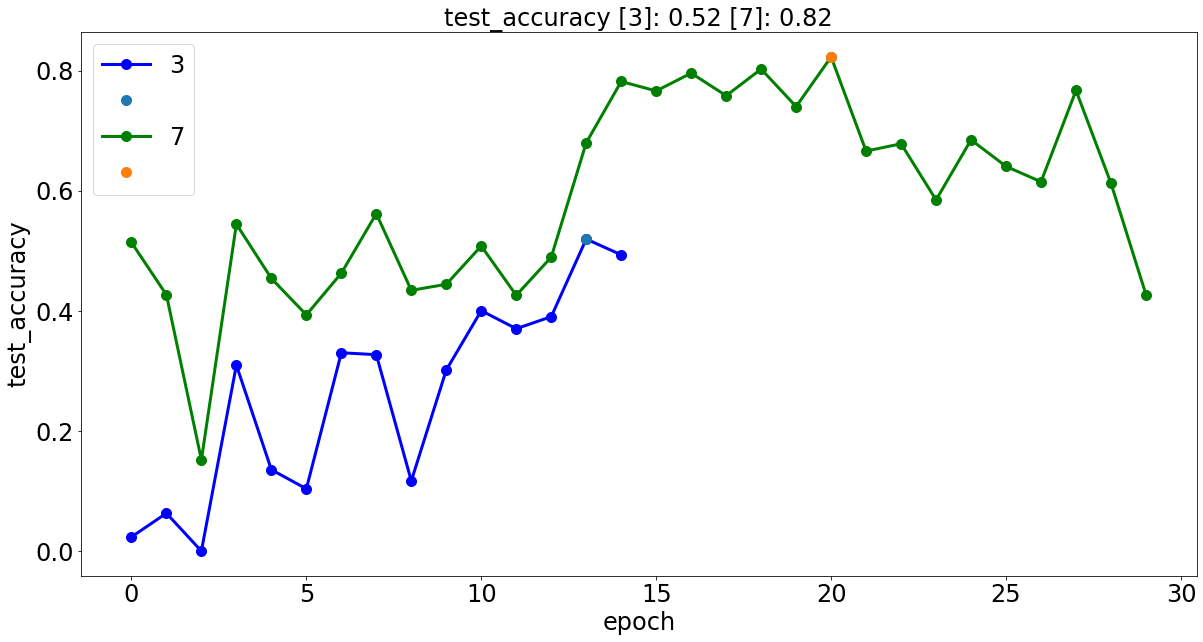

,epochs,offset,test_accuracy
3,15.0,0.1,0.519848
7,30.0,0.3,0.823344


In [ ]:
metric_visualization(experiments=[3, 7], metric='test_accuracy', backend='matplotlib')

## Using more than one visualization routine

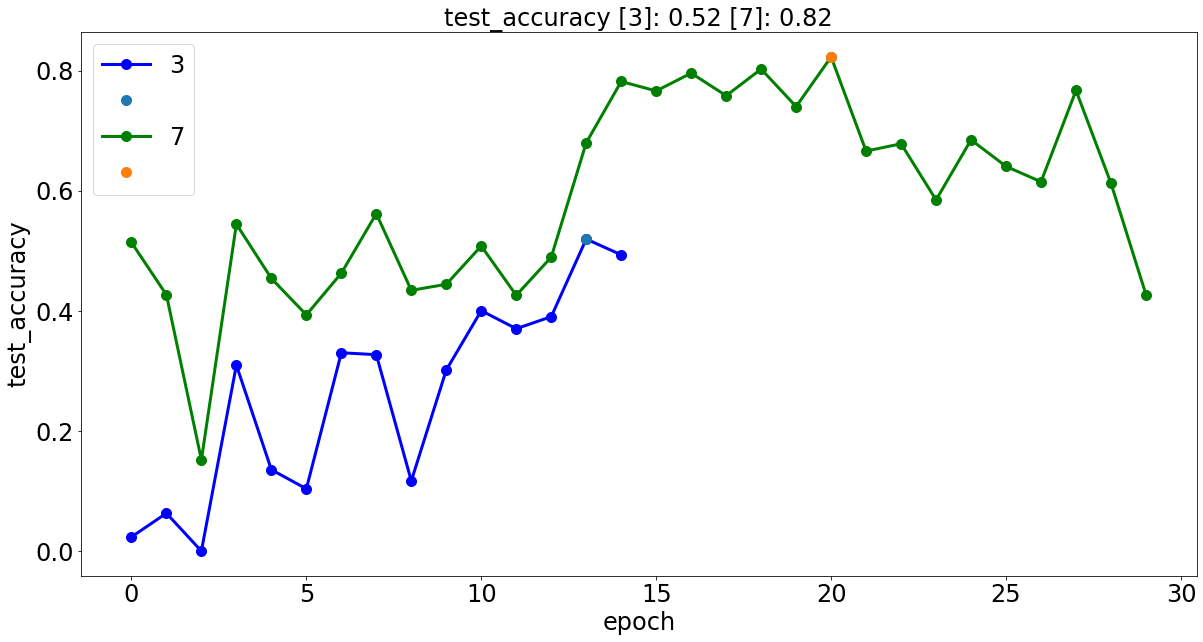

,epochs,offset,test_accuracy
3,15.0,0.1,0.519848
7,30.0,0.3,0.823344


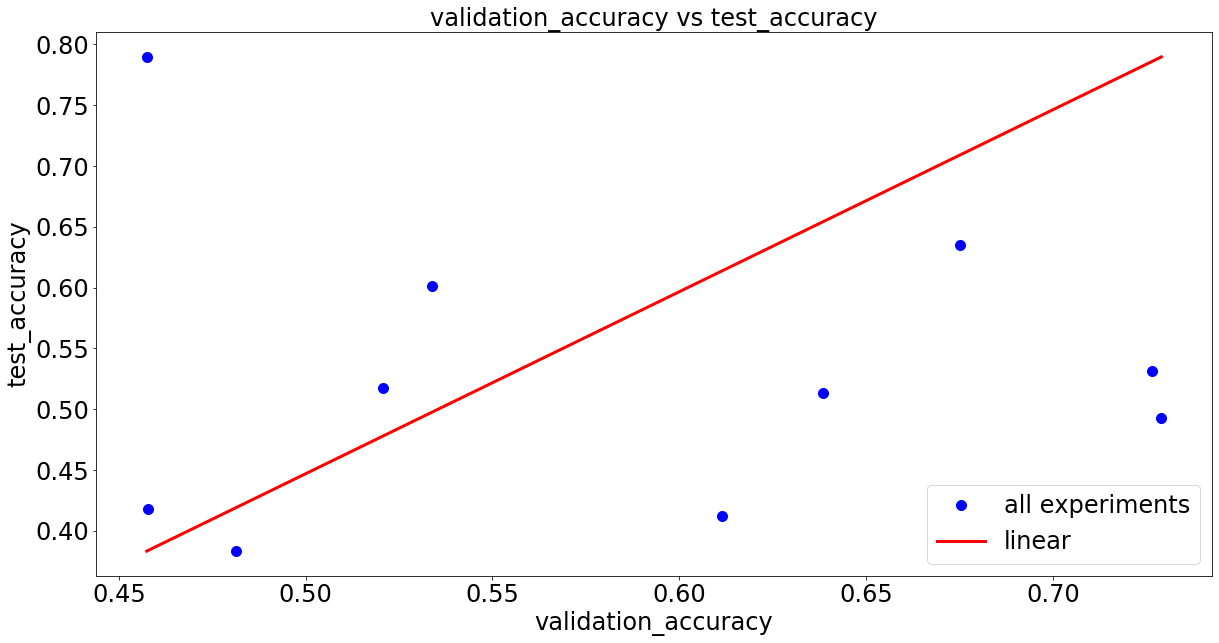

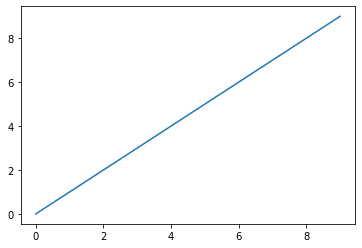

In [ ]:
metric_visualization(experiments=[3, 7], metric='test_accuracy', backend='matplotlib', 
                     visualization_options={'visualization': ['history', 'metric_correlation', 'custom'],
                                           'metric_1': 'validation_accuracy',
                                            'metric_2': 'test_accuracy'})

Test the command line parser

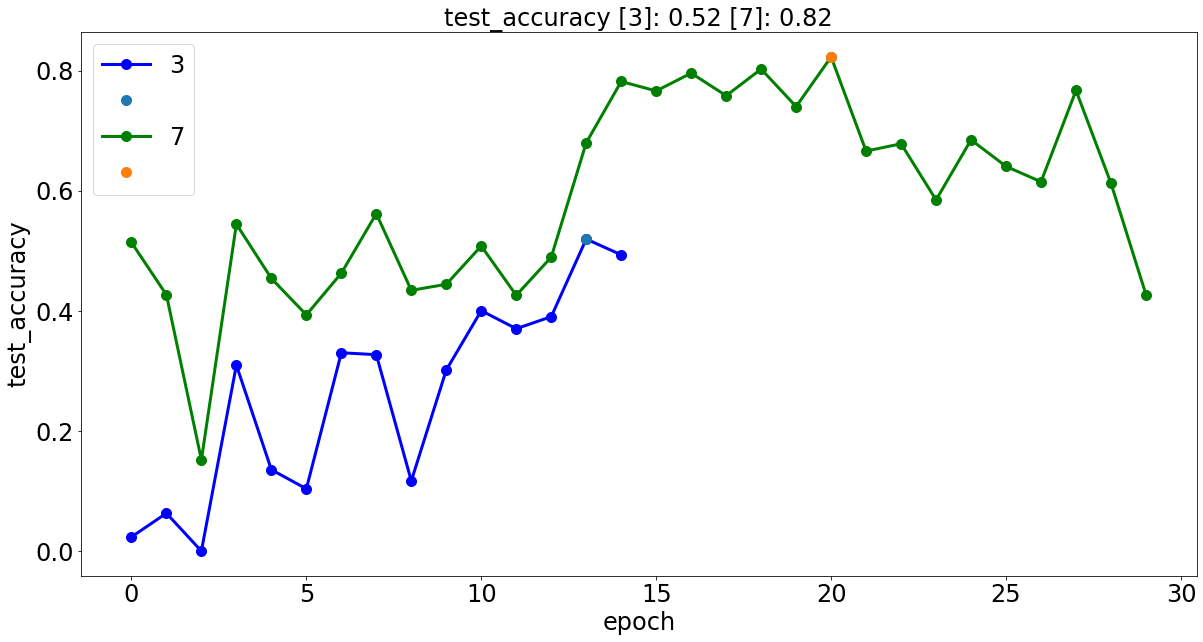

,epochs,offset,test_accuracy
3,15.0,0.1,0.519848
7,30.0,0.3,0.823344


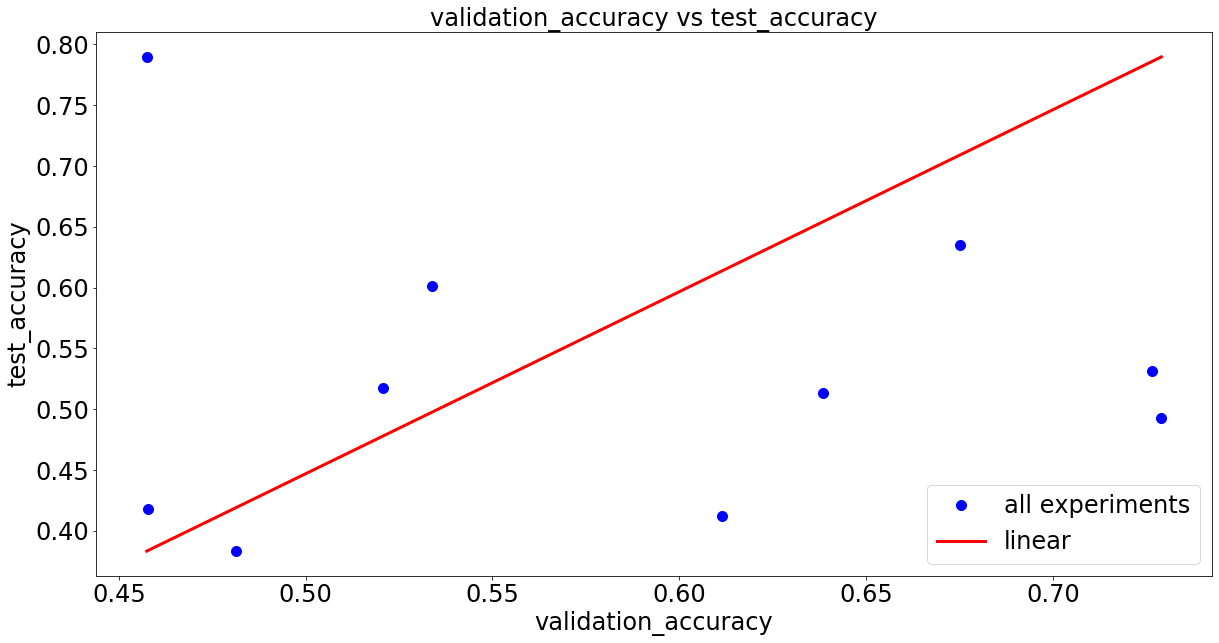

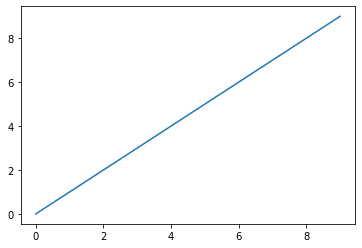

In [ ]:
parse_arguments_and_visualize (['-e', '3', '7', 
                                '-m', 'test_accuracy', 
                                '-b', 'matplotlib', 
                                '-v', '{"visualization": ["history", "metric_correlation", "custom"], "metric_1": "validation_accuracy", "metric_2": "test_accuracy"}'])

In [ ]:
#hide
from nbdev.export import *
notebook2script(recursive=True)